# Trabalho prático da disciplina de aprendizado de máquina 2020-01
## Instituto de computação da Universidade Federal Fluminense
### Professora: Flávia Bernardini
### Alunos: João Ricardo Weissmann Santos e Bruna Toledo

## Importando bibliotecas

In [1]:
%matplotlib inline
%lsmagic

import time
import math

import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler

from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn import svm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import LeaveOneOut

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor

import xgboost as xgb

## Definindo funções úteis

In [2]:
def graficos_boxplot(X, colunas=None, grupo=None, restricoes=None):
    
    if grupo == None:
        print ('nenhum grupo informado')
        return None
    
    if colunas == None: colunas = X.columns.tolist()
    
    dado = X[colunas + [grupo]].copy()
    
    for col in colunas:
        plt.figure(figsize=(16, 4))
        ax = sns.boxplot(x=grupo, y=col, data=dado)
        plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
        plt.xticks(rotation=45)
    return

def detectar_outliers(X, colunas=None, metodo='one class svm', contamination=0.1):
    
    if colunas == None: colunas = X.columns.tolist()
    
    x_local = X[colunas].copy()
    
    col_num = x_local.select_dtypes(include = ['float64', 'int64']).columns.tolist()
    col_cat = x_local.select_dtypes(include = ['object']).columns.tolist()
    
    for col in col_cat:
        enc = LabelEncoder()
        x_local[col] = enc.fit_transform(x_local[col].astype(str))
        
    for col in col_num:
        x_local[col].fillna(0, inplace=True)
        
    x_local['is outlier'] = 0
    
    dado = x_local[colunas]
    
    isolation_forest = IsolationForest(n_estimators=100, behaviour='new', contamination=contamination)
    robust_covariance = EllipticEnvelope(contamination=contamination)
    OneClassSVM = svm.OneClassSVM(kernel='poly', degree=2, gamma=1000, tol=0.1, nu=contamination)
    local_out_factor = LocalOutlierFactor(n_neighbors=35, contamination=contamination)
    
    if metodo == 'one class svm': out = OneClassSVM
    if metodo == 'isolation forest': out = isolation_forest
    if metodo == 'robust covariance': out = robust_covariance
    if metodo == 'local outlier fraction': out = local_out_factor
    
    if metodo == 'local outlier fraction':
        dado['is outlier'] = out.fit_predict(dado)
    else:
        out.fit(dado)
        dado['is outlier'] = out.predict(dado)
    
    mask = dado[dado['is outlier'] == -1].index.tolist()
    x_local.loc[mask, 'is outlier'] = 1
    
    return x_local['is outlier']

def preencher_buracos(X, coluna, valor = None, coluna_grupo = None):
    if valor != None: 
        X[coluna].fillna(valor, inplace=True)
    elif coluna_grupo == coluna:
        X[coluna].fillna(X[coluna].mean())
    else:
        mask = X[coluna].isnull()
        replace_dict = X[coluna, coluna_grupo].groupby(coluna_grupo).mean().to_dict()[coluna]
        X.loc[mask, coluna] = X[coluna_grupo][mask].replace(replace_dict)
    return X

def normalizar_numericas(X, colunas_numericas = None):
    if colunas_numericas == None: colunas_numericas = X.columns.tolist()
    scaler = RobustScaler()
    X[colunas_numericas] = scaler.fit_transform(X[colunas_numericas])
    return X, scaler

def codificar_categoricas(X, colunas_categoricas = None):
    if colunas_categoricas == None: colunas_categoricas = X.columns.tolist()
    colunas_numericas = [x for x in X.columns.tolist() if x not in colunas_categoricas]
    enc = OneHotEncoder(handle_unknown='ignore')
    X_cat = pd.DataFrame(enc.fit_transform(X[colunas_categoricas]).toarray())
    X.reset_index(inplace=True, drop=True)
    res = pd.concat([X_cat, X[colunas_numericas]], axis=1)
    return res, enc

def fitar_modelo(modelo, X, y, X_test = None, y_test = None):
    modelo.fit(X, y)
    train_score = r2_score(y, modelo.predict(X))
    test_score = r2_score(y_test, modelo.predict(X_test))
    if X_test == None:
        return modelo, train_score
    else:
        return modelo, train_score, test_score

def importancia_das_features(X, y, colunas_numericas = None, colunas_categoricas = None, nome_variavel = ''): 
    
    x_local = X.copy()
    y_local = y.copy()
    
    if colunas_numericas != None: x_local, _ = normalizar_numericas(x_local, colunas_numericas)
    if colunas_categoricas != None:
        for col in colunas_categoricas:
            enc = LabelEncoder()
            x_local[col] = enc.fit_transform(x_local[col].astype(str))
    
    features_names = x_local.columns
    
    rf_importance = RandomForestRegressor(n_estimators=100, n_jobs=-1)
    rf_importance.fit(x_local, y_local)
    
    feature_importances = list(rf_importance.feature_importances_)
    list_tuples = zip(features_names, feature_importances)
    
    plt.figure(123)
    plt.figure(figsize=(5, 10))
    features_names_sort, feature_importances_sort = zip(*sorted(list_tuples, key=lambda x:x[1], reverse=False)[:50])
    plt.barh(range(len(feature_importances_sort)), feature_importances_sort)
    plt.yticks(np.arange(len(features_names_sort)), features_names_sort)
    plt.title('Feature Importances - ' + nome_variavel)
    plt.show()
    
    return features_names_sort, feature_importances_sort

def calcular_correlação(X, colunas_numericas=None, colunas_categoricas=None):
    
    x_local = X.copy()
    colunas = []
    
    if colunas_numericas != None:
        x_local, _ = normalizar_numericas(x_local, colunas_numericas)
        colunas = colunas + colunas_numericas
    if colunas_categoricas != None:
        colunas = colunas + colunas_categoricas
        for col in colunas_categoricas:
            enc = LabelEncoder()
            x_local[col] = enc.fit_transform(x_local[col].astype(str))
    
    correlacao = {}
    for col in colunas:
        val = x_local.drop(col, axis=1).apply(lambda x: x.corr(x_local[col]))
        correlacao[col] = val.sort_values(ascending=False)
    
    df = pd.DataFrame(correlacao)
            
    return df

def selecionar_features(X, y, y_name=None, colunas_numericas=None, colunas_categoricas=None, limite_corr=0.8, limite_importancia=0.8, quantidade=999):
    
    x_local = X.copy()
    y_local = y.copy()
    
    if colunas_numericas != None and colunas_categoricas != None:
        corr = calcular_correlação(x_local, colunas_numericas=colunas_numericas, colunas_categoricas=colunas_categoricas)
        features_names_sort, feature_importances_sort = importancia_das_features(x_local, y_local, colunas_numericas=colunas_numericas, colunas_categoricas=colunas_categoricas, nome_variavel = y_name)
    elif colunas_numericas != None and colunas_categoricas == None:
        corr = calcular_correlação(x_local, colunas_numericas=colunas_numericas)
        features_names_sort, feature_importances_sort = importancia_das_features(x_local, y_local, colunas_numericas=colunas_numericas, nome_variavel = y_name)
    elif colunas_numericas == None and colunas_categoricas != None:
        corr = calcular_correlação(x_local, colunas_categoricas=colunas_categoricas)
        features_names_sort, feature_importances_sort = importancia_das_features(x_local, y_local, colunas_categoricas=colunas_categoricas, nome_variavel = y_name)
    else:
        print ("algo errado ai meu camarada")
        return None
    
    features = corr.columns.tolist()
    features_slct = []
    count = 0
    for f, v in zip(reversed(features_names_sort), reversed(feature_importances_sort)):
        print (f, v)
        if count > quantidade: break
        add = True
        if float(v) > limite_importancia: add = False
        for f_f in features_slct:
            if v < 0.001 or abs(corr.loc[f, f_f]) > limite_corr: add = False
        if add: 
            features_slct.append(f)
            count += 1
    
    x_features_slct = x_local[features_slct]
    return x_features_slct, features_slct

def busca_aleatoria(X, y, modelo, parametros, metrica, n_folds = 10, n_iter = 200):
    
    start_time = time.time()
    
    print ("\n \n buscando melhores parâmetros...")
    
    otm_model = RandomizedSearchCV(modelo, param_distributions=parametros, n_iter=n_iter, 
                                   scoring=metrica, cv=n_folds, n_jobs=1, refit=list(metrica.keys())[0])
    otm_model.fit(X, y)
    
    melhores_parametros = otm_model.best_params_
    melhor_modelo = otm_model.best_estimator_
    
    resultados = pd.DataFrame(otm_model.cv_results_)
    resultados.sort_values(by='rank_test_'+str(list(metrica.keys())[0]), inplace=True)
    print ("melhores parâmetros encontrados")
    
    end_time = time.time()
    otm_time = (end_time - start_time) / 60
    
    best_score = otm_model.best_score_
    
    return melhor_modelo, melhores_parametros, best_score, resultados, otm_time

## Importando o dado

In [3]:
ls data/

Fat_Supply_Quantity_Data.csv      Protein_Supply_Quantity_Data.csv
Food_Supply_kcal_Data.csv         readme.txt
Food_Supply_Quantity_kg_Data.csv  Supply_Food_Data_Descriptions.csv


In [4]:
fat_df = pd.read_csv('./data/Fat_Supply_Quantity_Data.csv')

In [5]:
fat_df.head()

,Country,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,...,Vegetable Oils,Vegetables,Obesity,Undernourished,Confirmed,Deaths,Recovered,Active,Population,Unit (all except Population)
0,Afghanistan,0.0,21.6397,6.2224,0.0,8.0353,0.6859,0.0327,0.4246,6.1244,...,17.0831,0.3593,4.5,29.8,0.021411,0.000492,0.002445,0.018474,38042000.0,%
1,Albania,0.0,32.0002,3.4172,0.0,2.6734,1.6448,0.1445,0.6418,8.7428,...,9.2443,0.6503,22.3,6.2,0.033730,0.001085,0.026522,0.006123,2858000.0,%
2,Algeria,0.0,14.4175,0.8972,0.0,4.2035,1.2171,0.2008,0.5772,3.8961,...,27.3606,0.5145,26.6,3.9,0.017375,0.001309,0.009142,0.006925,43406000.0,%
3,Angola,0.0,15.3041,1.3130,0.0,6.5545,0.1539,1.4155,0.3488,11.0268,...,22.4638,0.1231,6.8,25,0.000165,0.000010,0.000054,0.000102,31427000.0,%
4,Antigua and Barbuda,0.0,27.7033,4.6686,0.0,3.2153,0.3872,1.5263,1.2177,14.3202,...,14.4436,0.2469,19.1,NaN,0.025773,0.003093,0.019588,0.003093,97000.0,%


In [6]:
protein_df = pd.read_csv('./data/Protein_Supply_Quantity_Data.csv')

In [7]:
protein_df.head()

,Country,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,...,Vegetables,Miscellaneous,Obesity,Undernourished,Confirmed,Deaths,Recovered,Active,Population,Unit (all except Population)
0,Afghanistan,0.0000,9.7523,0.0277,0.0,35.9771,0.4067,0.0647,0.5824,3.1337,...,1.1370,0.0462,4.5,29.8,0.021411,0.000492,0.002445,0.018474,38042000.0,%
1,Albania,0.1840,27.7469,0.0711,0.0,14.2331,1.8069,0.6274,1.2757,7.6582,...,3.2456,0.0544,22.3,6.2,0.033730,0.001085,0.026522,0.006123,2858000.0,%
2,Algeria,0.0323,13.8360,0.0054,0.0,26.5633,1.2916,0.6350,1.1624,3.5088,...,3.1267,0.1399,26.6,3.9,0.017375,0.001309,0.009142,0.006925,43406000.0,%
3,Angola,0.6285,15.2311,0.0277,0.0,20.3882,0.1756,5.4436,1.2754,7.6248,...,0.8133,0.0924,6.8,25,0.000165,0.000010,0.000054,0.000102,31427000.0,%
4,Antigua and Barbuda,0.1535,33.1901,0.1289,0.0,10.5108,0.4850,8.2146,1.2586,16.0670,...,1.6024,0.2947,19.1,NaN,0.025773,0.003093,0.019588,0.003093,97000.0,%


In [8]:
kcal_df = pd.read_csv('./data/Food_Supply_kcal_Data.csv')

In [9]:
kcal_df.head()

,Country,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,...,Vegetable Oils,Vegetables,Obesity,Undernourished,Confirmed,Deaths,Recovered,Active,Population,Unit (all except Population)
0,Afghanistan,0.0000,4.7774,0.8504,0.0,37.1186,0.1501,0.0000,1.4757,1.2006,...,2.3012,0.7504,4.5,29.8,0.021411,0.000492,0.002445,0.018474,38042000.0,%
1,Albania,0.9120,16.0930,1.0591,0.0,16.2107,0.8091,0.1471,3.8982,3.8688,...,2.8244,2.7508,22.3,6.2,0.033730,0.001085,0.026522,0.006123,2858000.0,%
2,Algeria,0.0896,6.0326,0.1941,0.0,25.0112,0.4181,0.1195,3.1805,1.2543,...,5.7638,2.0457,26.6,3.9,0.017375,0.001309,0.009142,0.006925,43406000.0,%
3,Angola,1.9388,4.6927,0.2644,0.0,18.3521,0.0441,0.8372,2.3133,2.9302,...,4.2741,0.3525,6.8,25,0.000165,0.000010,0.000054,0.000102,31427000.0,%
4,Antigua and Barbuda,2.3041,15.3672,1.5429,0.0,13.7215,0.2057,1.7280,3.6824,7.0356,...,4.6904,1.2960,19.1,NaN,0.025773,0.003093,0.019588,0.003093,97000.0,%


In [10]:
quantity_kg_df = pd.read_csv('./data/Food_Supply_Quantity_kg_Data.csv')

In [11]:
quantity_kg_df.head()

,Country,Alcoholic Beverages,Animal fats,Animal Products,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,...,Vegetables,Vegetal Products,Obesity,Undernourished,Confirmed,Deaths,Recovered,Active,Population,Unit (all except Population)
0,Afghanistan,0.0014,0.1973,9.4341,0.0,24.8097,0.2099,0.0350,5.3495,1.2020,...,6.7642,40.5645,4.5,29.8,0.021411,0.000492,0.002445,0.018474,38042000.0,%
1,Albania,1.6719,0.1357,18.7684,0.0,5.7817,0.5815,0.2126,6.7861,1.8845,...,11.7753,31.2304,22.3,6.2,0.033730,0.001085,0.026522,0.006123,2858000.0,%
2,Algeria,0.2711,0.0282,9.6334,0.0,13.6816,0.5277,0.2416,6.3801,1.1305,...,11.6484,40.3651,26.6,3.9,0.017375,0.001309,0.009142,0.006925,43406000.0,%
3,Angola,5.8087,0.0560,4.9278,0.0,9.1085,0.0587,1.7707,6.0005,2.0571,...,2.3041,45.0722,6.8,25,0.000165,0.000010,0.000054,0.000102,31427000.0,%
4,Antigua and Barbuda,3.5764,0.0087,16.6613,0.0,5.9960,0.2274,4.1489,10.7451,5.6888,...,5.4495,33.3233,19.1,NaN,0.025773,0.003093,0.019588,0.003093,97000.0,%


In [12]:
description_df = pd.read_csv('./data/Supply_Food_Data_Descriptions.csv')

In [13]:
description_df.head()

,Categories,Items
0,Alcoholic Beverages,"Alcohol, Non-Food; Beer; Beverages, Alcoholic;..."
1,Animal fats,"Butter, Ghee; Cream; Fats, Animals, Raw; Fish,..."
2,Animal Products,"Aquatic Animals, Others; Aquatic Plants; Bovin..."
3,"Aquatic Products, Other","Aquatic Animals, Others; Aquatic Plants; Meat,..."
4,Cereals - Excluding Beer,"Barley and products; Cereals, Other; Maize and..."


## Juntando datasets

In [14]:
dfs = [fat_df, protein_df, kcal_df, quantity_kg_df, description_df]

In [15]:
for df in dfs:
    print (df.shape)

(170, 32)
(170, 32)
(170, 32)
(170, 32)
(23, 2)


In [16]:
cols = {}
i = 0
for df in dfs[:-1]:
    i += 1
    cols['df'+str(i)] = list(df.columns)
df_cols = pd.DataFrame(cols)

In [17]:
df_cols

,df1,df2,df3,df4
0,Country,Country,Country,Country
1,Alcoholic Beverages,Alcoholic Beverages,Alcoholic Beverages,Alcoholic Beverages
2,Animal Products,Animal Products,Animal Products,Animal fats
3,Animal fats,Animal fats,Animal fats,Animal Products
4,"Aquatic Products, Other","Aquatic Products, Other","Aquatic Products, Other","Aquatic Products, Other"
5,Cereals - Excluding Beer,Cereals - Excluding Beer,Cereals - Excluding Beer,Cereals - Excluding Beer
6,Eggs,Eggs,Eggs,Eggs
7,"Fish, Seafood","Fish, Seafood","Fish, Seafood","Fish, Seafood"
8,Fruits - Excluding Wine,Fruits - Excluding Wine,Fruits - Excluding Wine,Fruits - Excluding Wine
9,Meat,Meat,Meat,Meat


In [18]:
shared_cols = ['Country', 'Obesity', 'Undernourished', 'Confirmed', 'Deaths', 'Recovered', 'Active', 'Population', 'Unit (all except Population)']

In [19]:
dataset = fat_df[shared_cols].copy()

In [20]:
dataset.head()

,Country,Obesity,Undernourished,Confirmed,Deaths,Recovered,Active,Population,Unit (all except Population)
0,Afghanistan,4.5,29.8,0.021411,0.000492,0.002445,0.018474,38042000.0,%
1,Albania,22.3,6.2,0.033730,0.001085,0.026522,0.006123,2858000.0,%
2,Algeria,26.6,3.9,0.017375,0.001309,0.009142,0.006925,43406000.0,%
3,Angola,6.8,25,0.000165,0.000010,0.000054,0.000102,31427000.0,%
4,Antigua and Barbuda,19.1,NaN,0.025773,0.003093,0.019588,0.003093,97000.0,%


In [21]:
cols = list(fat_df.columns)

In [22]:
cols = ['Country'] + [i for i in cols if i not in shared_cols]

In [23]:
fat_df = fat_df[cols].copy()

In [24]:
protein_df = protein_df[cols].copy()

In [25]:
kcal_df = kcal_df[cols].copy()

In [26]:
quantity_kg_df = quantity_kg_df[cols].copy()

In [27]:
fat_cols_map = {i:i+'_fat' for i in cols if i != 'Country'}

In [28]:
protein_cols_map = {i:i+'_protein' for i in cols if i != 'Country'}

In [29]:
kcal_cols_map = {i:i+'_kcal' for i in cols if i != 'Country'}

In [30]:
quant_cols_map = {i:i+'_quantity' for i in cols if i != 'Country'}

In [31]:
fat_df.rename(fat_cols_map, axis=1, inplace=True)

In [32]:
protein_df.rename(protein_cols_map, axis=1, inplace=True)

In [33]:
kcal_df.rename(kcal_cols_map, axis=1, inplace=True)

In [34]:
quantity_kg_df.rename(quant_cols_map, axis=1, inplace=True)

In [35]:
dfs = [kcal_df]

In [36]:
for i, _ in enumerate(dfs):
    dataset = dataset.merge(dfs[i].copy(), how='left', on='Country', copy=False)

In [37]:
dataset.shape

(170, 32)

## Analisando o dado

In [38]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170 entries, 0 to 169
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Country                        170 non-null    object 
 1   Obesity                        167 non-null    float64
 2   Undernourished                 163 non-null    object 
 3   Confirmed                      161 non-null    float64
 4   Deaths                         161 non-null    float64
 5   Recovered                      161 non-null    float64
 6   Active                         161 non-null    float64
 7   Population                     170 non-null    float64
 8   Unit (all except Population)   170 non-null    object 
 9   Alcoholic Beverages_kcal       170 non-null    float64
 10  Animal Products_kcal           170 non-null    float64
 11  Animal fats_kcal               170 non-null    float64
 12  Aquatic Products, Other_kcal   170 non-null    flo

In [39]:
dataset.dtypes.value_counts()

float64    29
object      3
dtype: int64

In [40]:
data_num = dataset.select_dtypes(include = ['float64', 'int64'])
data_cat = dataset.select_dtypes(include = ['object'])

In [41]:
data_cat.head()

,Country,Undernourished,Unit (all except Population)
0,Afghanistan,29.8,%
1,Albania,6.2,%
2,Algeria,3.9,%
3,Angola,25,%
4,Antigua and Barbuda,NaN,%


In [42]:
data_num.describe()

,Obesity,Confirmed,Deaths,Recovered,Active,Population,Alcoholic Beverages_kcal,Animal Products_kcal,Animal fats_kcal,"Aquatic Products, Other_kcal",...,Pulses_kcal,Spices_kcal,Starchy Roots_kcal,Stimulants_kcal,Sugar Crops_kcal,Sugar & Sweeteners_kcal,Treenuts_kcal,Vegetal Products_kcal,Vegetable Oils_kcal,Vegetables_kcal
count,167.000000,161.000000,161.000000,161.000000,161.000000,1.700000e+02,170.000000,170.000000,170.000000,170.000000,...,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,18.707784,0.083872,0.004454,0.042839,0.036576,4.408395e+07,1.325197,9.294553,1.267419,0.002786,...,1.108887,0.183202,3.083885,0.305375,0.017877,4.821161,0.261619,40.707045,4.872421,1.086328
std,9.633557,0.127583,0.011492,0.085173,0.067335,1.556265e+08,1.062362,4.754174,1.283723,0.030879,...,1.204642,0.237672,3.892900,0.312164,0.071444,2.140639,0.285631,4.754308,2.164249,0.648232
min,2.100000,0.000047,0.000000,0.000000,0.000000,5.300000e+04,0.000000,1.623700,0.000000,0.000000,...,0.000000,0.000000,0.293800,0.000000,0.000000,0.678600,0.000000,27.708900,0.932500,0.095700
25%,8.500000,0.006013,0.000147,0.002235,0.001395,2.822750e+06,0.361300,5.082600,0.342850,0.000000,...,0.296675,0.036350,1.112325,0.077650,0.000000,3.422175,0.046625,36.830725,3.126350,0.602600
50%,21.200000,0.022222,0.000545,0.009806,0.008685,1.014600e+07,1.244600,9.034100,0.877500,0.000000,...,0.708400,0.085900,1.544850,0.206750,0.000000,4.678350,0.174000,40.969700,4.660650,1.003100
75%,25.700000,0.116800,0.002828,0.048328,0.030238,3.169250e+07,2.028050,13.174975,1.763175,0.000000,...,1.547150,0.227975,2.924450,0.420800,0.000000,6.345800,0.389575,44.940900,6.427900,1.366950
max,45.600000,0.640484,0.079857,0.601290,0.353151,1.398030e+09,5.157400,22.291100,7.800700,0.400700,...,7.563800,1.220200,19.675900,2.009000,0.593000,9.549200,1.421000,48.386400,10.383900,3.352400


In [43]:
dataset.isnull().sum()

Country                          0
Obesity                          3
Undernourished                   7
Confirmed                        9
Deaths                           9
Recovered                        9
Active                           9
Population                       0
Unit (all except Population)     0
Alcoholic Beverages_kcal         0
Animal Products_kcal             0
Animal fats_kcal                 0
Aquatic Products, Other_kcal     0
Cereals - Excluding Beer_kcal    0
Eggs_kcal                        0
Fish, Seafood_kcal               0
Fruits - Excluding Wine_kcal     0
Meat_kcal                        0
Miscellaneous_kcal               0
Milk - Excluding Butter_kcal     0
Offals_kcal                      0
Oilcrops_kcal                    0
Pulses_kcal                      0
Spices_kcal                      0
Starchy Roots_kcal               0
Stimulants_kcal                  0
Sugar Crops_kcal                 0
Sugar & Sweeteners_kcal          0
Treenuts_kcal       

In [44]:
for col, val in zip(dataset.isnull().sum().index.to_list(), list(dataset.isnull().sum().values)):
    if val > 0:
        print (col, val) 

Obesity 3
Undernourished 7
Confirmed 9
Deaths 9
Recovered 9
Active 9


In [45]:
dataset = dataset[dataset['Confirmed'].isnull() != True]

In [46]:
dataset.shape

(161, 32)

In [47]:
for col, val in zip(dataset.isnull().sum().index.to_list(), list(dataset.isnull().sum().values)):
    if val > 0:
        print (col, val) 

Obesity 1
Undernourished 7


In [48]:
dataset['Undernourished'].unique()

array(['29.8', '6.2', '3.9', '25', nan, '4.6', '4.3', '<2.5', '14.7',
       '7.5', '10.1', '17.1', '26.4', '3.6', '20', '12.6', '16.4', '9.9',
       '59.6', '37.5', '2.7', '8.5', '4.8', '40.3', '19', '5.6', '18.9',
       '9.5', '7.9', '4.5', '9', '2.9', '20.6', '3.7', '10.5', '10.2',
       '5.5', '15.2', '16.5', '28', '8.1', '49.3', '12.9', '14.5', '8.3',
       '4.9', '29', '8', '12.2', '29.4', '2.8', '7.1', '11', '13.1',
       '37.2', '44.4', '17.5', '2.5', '10.3', '6.3', '10.4', '6.5',
       '13.4', '3.4', '27.9', '27.3', '8.7', '17', '3.2', '6.8', '20.3',
       '10', '10.7', '9.7', '13.3', '36.8', '5.7', '7', '11.3', '25.6',
       '20.1', '3.5', '7.8', '24.9', '16.1', '41', '2.6', '30.7', '21.2',
       '9.3', '38.9', '46.7', '51.3'], dtype=object)

In [49]:
dataset.loc[dataset['Undernourished'] == '<2.5', 'Undernourished'] = '2.5'

In [50]:
dataset['Undernourished'] = dataset['Undernourished'].astype(float)

In [51]:
dataset['Obesity'].unique()

array([ 4.5, 22.3, 26.6,  6.8, 19.1, 28.5, 20.9, 30.4, 21.9, 19.9, 32.1,
        3.4, 24.8, 24.5, 22.4,  8.2, 18.7, 19.4, 16.1, 27.4, 10.6,  3.5,
        9.5, 31.3,  6.3,  4.8, 28.8,  6.6, 22.1,  8.4, 25.7,  9. , 27.1,
       26.7, 22.6, 21.3, 12.2, 28.2, 26.9, 19.3, 31.1, 22.7, 23.8, 13.5,
        3.6, 30. , 24.9, 23.2, 13.4,  8.7, 23.3,  9.7, 20.2, 18.8, 19.2,
       20.5, 28.6, 23.1,  3.8,  6.9, 25.5, 22.9, 24.4,  4.4, 33.4,  6. ,
        4.9, 37. , 15.4,  8.6, 28.4, 24.2,  4.7, 15.3,  7.9,  7.1, 31. ,
       11.3, 11.5, 19.6, 25.6, 15. , 32. , 21.8,  7.8, 23.9, 25. , 22.5,
       19. , 20.1, 19.8, 35. ,  7.4, 23.5,  7.5, 27. ,  5.4, 26.5, 21.2,
        nan, 12.6, 10.8,  2.9, 19.7, 27.3, 32.2,  4.1, 26.1, 29.9, 29.5,
       37.3, 28.9, 25.2,  2.1, 14.1,  6.5, 12.3])

In [52]:
dataset['Obesity'] = dataset['Obesity'].astype(float)

In [53]:
dataset['Obesity'].fillna(dataset['Obesity'].mean(), inplace=True)

In [54]:
dataset['Undernourished'].fillna(dataset['Undernourished'].mean(), inplace=True)

In [55]:
dataset.isnull().sum().unique()

array([0])

## Correlações importantes (Golden features)

In [56]:
targets = ['Confirmed', 'Deaths', 'Recovered', 'Active']

In [57]:
golden_features_dict = {}
data_num = dataset.select_dtypes(include = ['float64', 'int64'])
for t in targets:
    data_corr = data_num.corr()[t]
    golden_features_list = data_corr[abs(data_corr) > 0.2].sort_values(ascending=False)
    golden_features_list.drop(targets, inplace=True)
    golden_features_dict[t] = golden_features_list.copy()
    print (t, golden_features_list)

Confirmed Animal Products_kcal             0.482963
Eggs_kcal                        0.429222
Obesity                          0.419346
Milk - Excluding Butter_kcal     0.401307
Animal fats_kcal                 0.395164
Stimulants_kcal                  0.386813
Alcoholic Beverages_kcal         0.369625
Meat_kcal                        0.341846
Treenuts_kcal                    0.336915
Vegetable Oils_kcal              0.224179
Oilcrops_kcal                   -0.217998
Pulses_kcal                     -0.252838
Undernourished                  -0.375300
Cereals - Excluding Beer_kcal   -0.414455
Vegetal Products_kcal           -0.483119
Name: Confirmed, dtype: float64
Deaths Animal fats_kcal                 0.367257
Animal Products_kcal             0.355175
Vegetable Oils_kcal              0.302832
Milk - Excluding Butter_kcal     0.290102
Alcoholic Beverages_kcal         0.286849
Eggs_kcal                        0.286821
Treenuts_kcal                    0.271012
Obesity                    

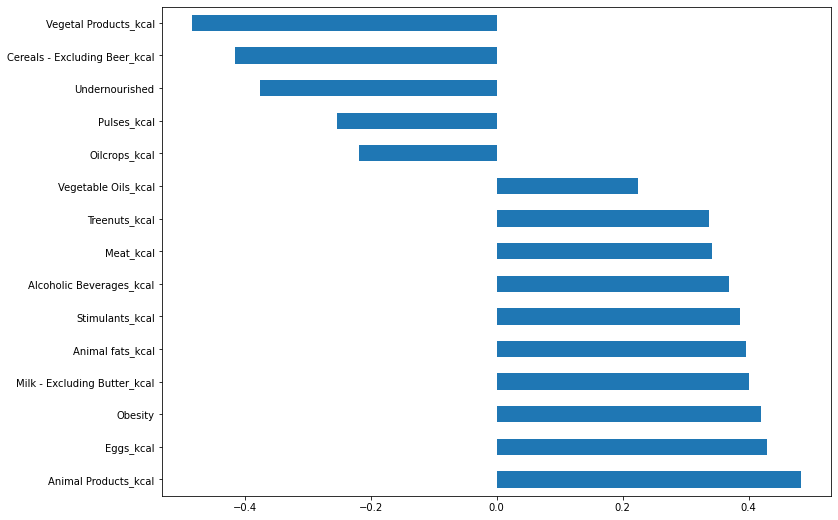

In [58]:
plt.figure(figsize=(12, 9))
golden_features_dict['Confirmed'].plot(kind='barh')

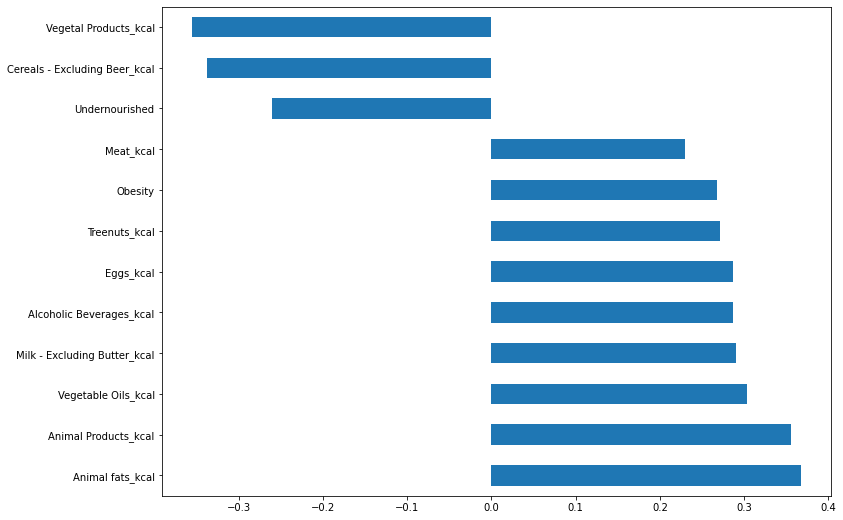

In [59]:
plt.figure(figsize=(12, 9))
golden_features_dict['Deaths'].plot(kind='barh')

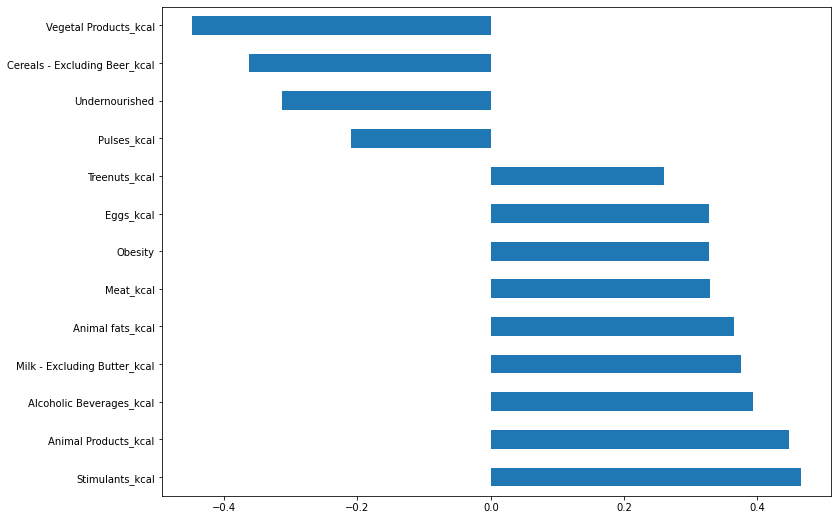

In [60]:
plt.figure(figsize=(12, 9))
golden_features_dict['Recovered'].plot(kind='barh')

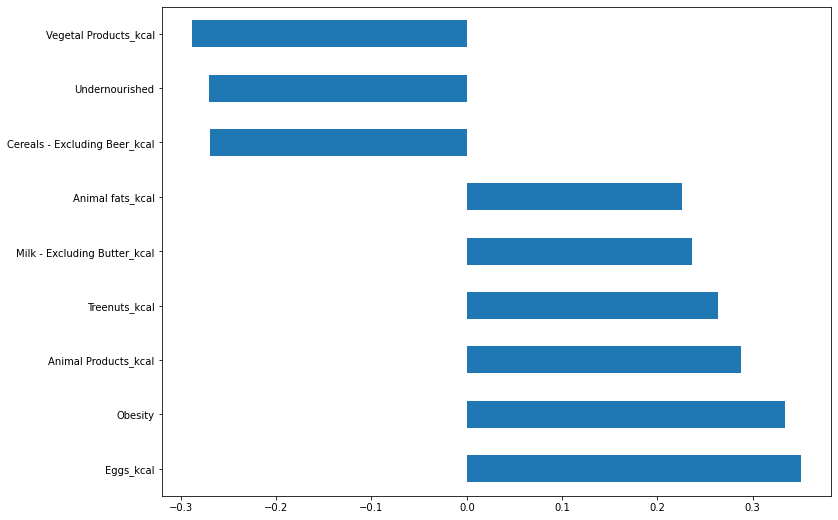

In [61]:
plt.figure(figsize=(12, 9))
golden_features_dict['Active'].plot(kind='barh')

## Remover outliers

In [62]:
colunas_outlier = data_num.columns.to_list()

dataset['is outlier'] = detectar_outliers(dataset, colunas=colunas_outlier, metodo='local outlier fraction', 
                                          contamination=0.000001)
print (str(list(dataset['is outlier']).count(1)) + ' outliers detectados')
dataset = dataset[dataset['is outlier']==0]

1 outliers detectados


## Separando features das targets

In [63]:
y_dict = {}
for t in targets:
    y_dict[t] = dataset[t]

## Feature engineering

In [64]:
cols = dataset.columns.to_list()

In [65]:
features = [f for f in cols if f not in targets]

x_features = dataset[features].copy()

In [66]:
x_features.head()

,Country,Obesity,Undernourished,Population,Unit (all except Population),Alcoholic Beverages_kcal,Animal Products_kcal,Animal fats_kcal,"Aquatic Products, Other_kcal",Cereals - Excluding Beer_kcal,...,Spices_kcal,Starchy Roots_kcal,Stimulants_kcal,Sugar Crops_kcal,Sugar & Sweeteners_kcal,Treenuts_kcal,Vegetal Products_kcal,Vegetable Oils_kcal,Vegetables_kcal,is outlier
0,Afghanistan,4.5,29.800000,38042000.0,%,0.0000,4.7774,0.8504,0.0,37.1186,...,0.1001,0.3252,0.0750,0.0,2.2261,0.1251,45.2476,2.3012,0.7504,0
1,Albania,22.3,6.200000,2858000.0,%,0.9120,16.0930,1.0591,0.0,16.2107,...,0.0000,1.2651,0.2501,0.0,3.4422,0.3972,33.9070,2.8244,2.7508,0
2,Algeria,26.6,3.900000,43406000.0,%,0.0896,6.0326,0.1941,0.0,25.0112,...,0.1195,1.9262,0.1493,0.0,3.9869,0.2240,43.9749,5.7638,2.0457,0
3,Angola,6.8,25.000000,31427000.0,%,1.9388,4.6927,0.2644,0.0,18.3521,...,0.0000,12.6239,0.0441,0.0,2.7539,0.0000,45.3184,4.2741,0.3525,0
4,Antigua and Barbuda,19.1,11.258442,97000.0,%,2.3041,15.3672,1.5429,0.0,13.7215,...,0.3497,0.8434,0.4937,0.0,5.8218,0.0823,34.6225,4.6904,1.2960,0


In [67]:
del x_features['Unit (all except Population)']

In [68]:
del x_features['is outlier']

In [69]:
x_features.dtypes.value_counts()

float64    26
object      1
dtype: int64

In [70]:
x_features_orig = x_features.copy()

In [71]:
data_num = x_features.select_dtypes(include = ['float64', 'int64'])
data_cat = x_features.select_dtypes(include = ['object'])
colunas_a_normalizar = data_num.columns.tolist()
colunas_a_codificar = data_cat.columns.tolist()

<Figure size 432x288 with 0 Axes>

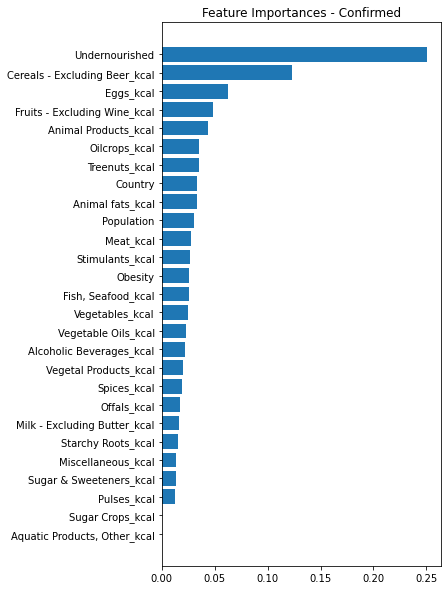

<Figure size 432x288 with 0 Axes>

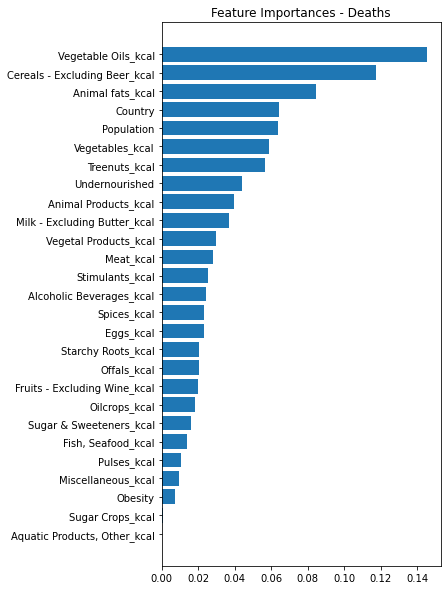

<Figure size 432x288 with 0 Axes>

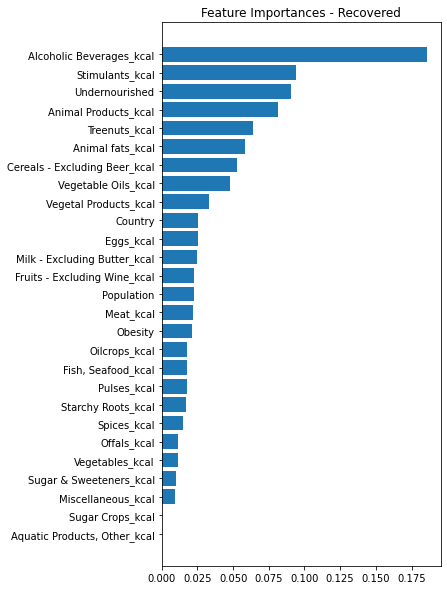

<Figure size 432x288 with 0 Axes>

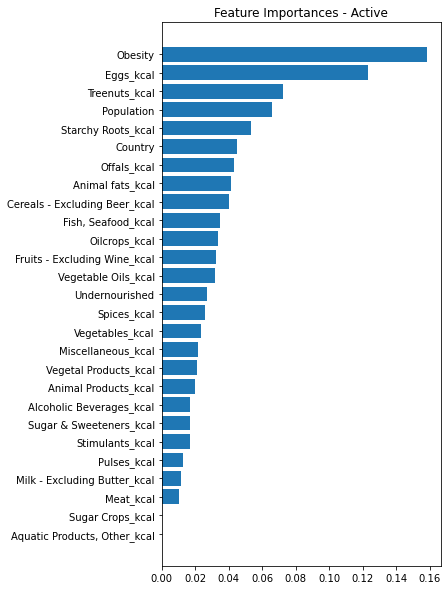

In [72]:
features_importances_dict = {}
features_names_dict = {}
for t in targets:
    features_names_sort, feature_importances_sort = importancia_das_features(x_features, y_dict[t], colunas_numericas=colunas_a_normalizar, colunas_categoricas=colunas_a_codificar, nome_variavel = t)
    features_importances_dict[t] = feature_importances_sort
    features_names_dict[t] = features_names_sort

<Figure size 432x288 with 0 Axes>

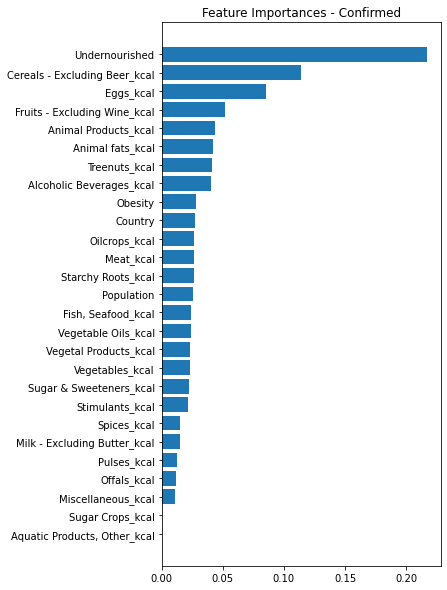

Undernourished 0.21743541657994522
Cereals - Excluding Beer_kcal 0.11418504164464084
Eggs_kcal 0.08519844137030254
Fruits - Excluding Wine_kcal 0.052162955290493716
Animal Products_kcal 0.043232645930908725
Animal fats_kcal 0.04201609797096385
Treenuts_kcal 0.04145148213522999
Alcoholic Beverages_kcal 0.04044358586712219
Obesity 0.027772924669826053
Country 0.027520987516501737
Oilcrops_kcal 0.026799009373812167
Meat_kcal 0.026404347566377776
Starchy Roots_kcal 0.026200272001796122
Population 0.02529945669662189
Fish, Seafood_kcal 0.024353352804380467
Vegetable Oils_kcal 0.023632934026131636
Vegetal Products_kcal 0.02355092990117265
Vegetables_kcal 0.02306209038740018
Sugar & Sweeteners_kcal 0.02225862373010964
Stimulants_kcal 0.021899753080839236
Spices_kcal 0.015122633523705603
Milk - Excluding Butter_kcal 0.01509694337755422
Pulses_kcal 0.012382734888479557
Offals_kcal 0.011962439933173988
Miscellaneous_kcal 0.010484837881309541
Sugar Crops_kcal 6.917607535964497e-05
Aquatic Product

<Figure size 432x288 with 0 Axes>

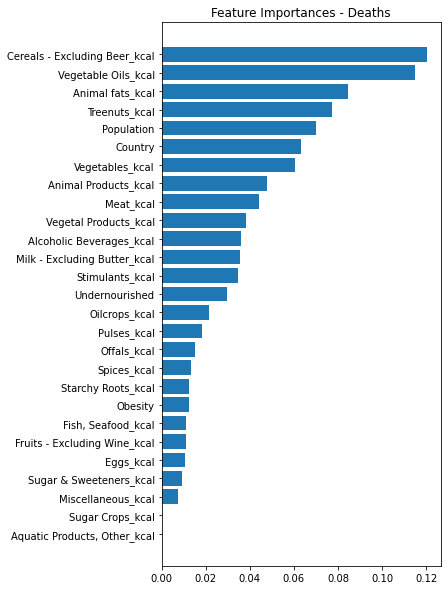

Cereals - Excluding Beer_kcal 0.12057128755533915
Vegetable Oils_kcal 0.11507643235520403
Animal fats_kcal 0.08476214451301263
Treenuts_kcal 0.0770704415976697
Population 0.06997226021393903
Country 0.06319635849403067
Vegetables_kcal 0.06061702030259093
Animal Products_kcal 0.047632525347197384
Meat_kcal 0.044029991701808366
Vegetal Products_kcal 0.03839612903259026
Alcoholic Beverages_kcal 0.03608720507239489
Milk - Excluding Butter_kcal 0.03530493406901293
Stimulants_kcal 0.034791422291735555
Undernourished 0.029768605243958985
Oilcrops_kcal 0.02154284694099093
Pulses_kcal 0.018318243967626397
Offals_kcal 0.015317557192738225
Spices_kcal 0.013464799242225451
Starchy Roots_kcal 0.012473557831159172
Obesity 0.01234533580114442
Fish, Seafood_kcal 0.010917390871259158
Fruits - Excluding Wine_kcal 0.010857201013977165
Eggs_kcal 0.010747166760293605
Sugar & Sweeteners_kcal 0.00920684986862432
Miscellaneous_kcal 0.007300568333554486
Sugar Crops_kcal 0.00023172438592219166
Aquatic Products,

<Figure size 432x288 with 0 Axes>

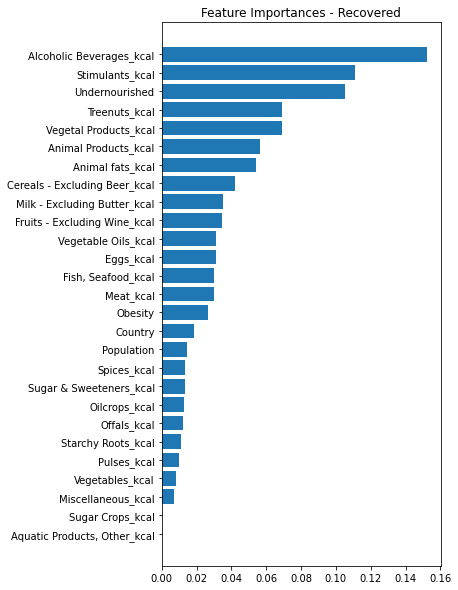

Alcoholic Beverages_kcal 0.15257929303242518
Stimulants_kcal 0.11085244487083623
Undernourished 0.10503524989420138
Treenuts_kcal 0.06925671491622964
Vegetal Products_kcal 0.06911670067002727
Animal Products_kcal 0.0562724591134461
Animal fats_kcal 0.054424723236830265
Cereals - Excluding Beer_kcal 0.0421414743819949
Milk - Excluding Butter_kcal 0.03512165290360428
Fruits - Excluding Wine_kcal 0.03479251390495262
Vegetable Oils_kcal 0.031392580455414015
Eggs_kcal 0.03091220297209188
Fish, Seafood_kcal 0.030284638658966054
Meat_kcal 0.030102127676987236
Obesity 0.026553860174553554
Country 0.01877113718992252
Population 0.014563713217219998
Spices_kcal 0.013622015977643833
Sugar & Sweeteners_kcal 0.013102298616607982
Oilcrops_kcal 0.012863104955792334
Offals_kcal 0.012129508229405173
Starchy Roots_kcal 0.010842966122383408
Pulses_kcal 0.009870385811211295
Vegetables_kcal 0.007973310143519107
Miscellaneous_kcal 0.007121013982724398
Sugar Crops_kcal 0.0002915922102036596
Aquatic Products,

<Figure size 432x288 with 0 Axes>

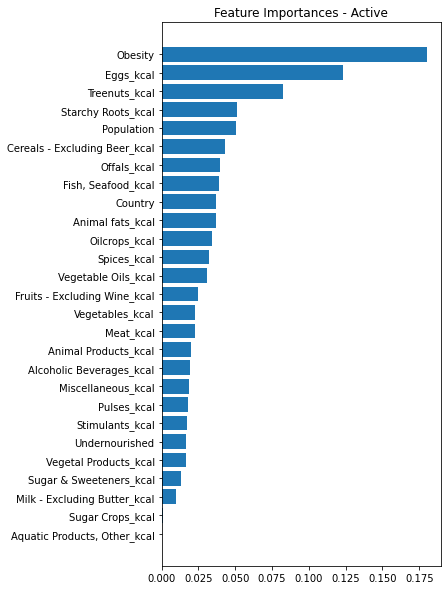

Obesity 0.18058090777029875
Eggs_kcal 0.12325799562335205
Treenuts_kcal 0.08247863729309392
Starchy Roots_kcal 0.05151069853034587
Population 0.05047545047876289
Cereals - Excluding Beer_kcal 0.04301659013078008
Offals_kcal 0.03983818682261516
Fish, Seafood_kcal 0.03870952779521557
Country 0.036898333330895934
Animal fats_kcal 0.03659976916228174
Oilcrops_kcal 0.03414975625104299
Spices_kcal 0.032151632543981463
Vegetable Oils_kcal 0.030912617538813733
Fruits - Excluding Wine_kcal 0.024509063996993666
Vegetables_kcal 0.022793339089109424
Meat_kcal 0.022691825347326743
Animal Products_kcal 0.019874727265532965
Alcoholic Beverages_kcal 0.019011928291996483
Miscellaneous_kcal 0.018858237872038233
Pulses_kcal 0.017764707088600902
Stimulants_kcal 0.017390536264258717
Undernourished 0.01641942325114767
Vegetal Products_kcal 0.016392371054402347
Sugar & Sweeteners_kcal 0.012885408164198446
Milk - Excluding Butter_kcal 0.009900281349400193
Sugar Crops_kcal 0.0007961006359997195
Aquatic Product

In [73]:
x_features_slct = {}
features_slct = {}
for t in targets:
    x_features_slct[t], features_slct[t] = selecionar_features(x_features, y_dict[t], y_name=t, colunas_numericas=colunas_a_normalizar, colunas_categoricas=colunas_a_codificar, limite_corr=0.9, limite_importancia=0.99, quantidade=99)


In [74]:
for t in targets:
    print (t + " " +str(len(features_slct[t])))

Confirmed 24
Deaths 24
Recovered 24
Active 24


<Figure size 432x288 with 0 Axes>

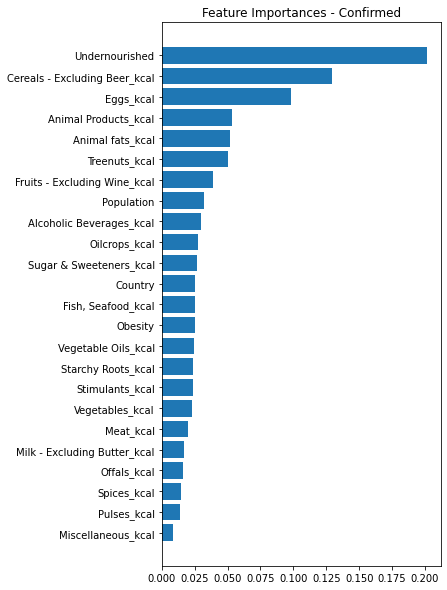

<Figure size 432x288 with 0 Axes>

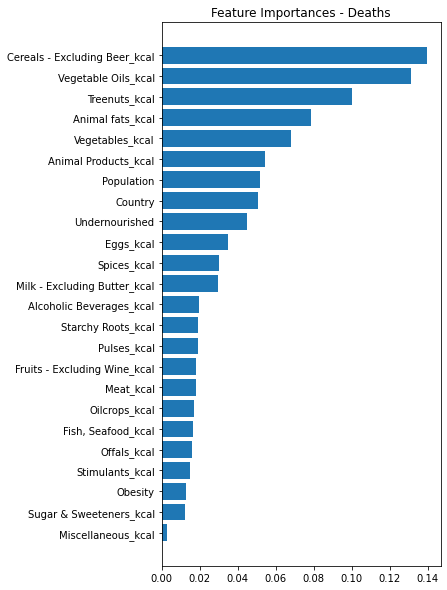

<Figure size 432x288 with 0 Axes>

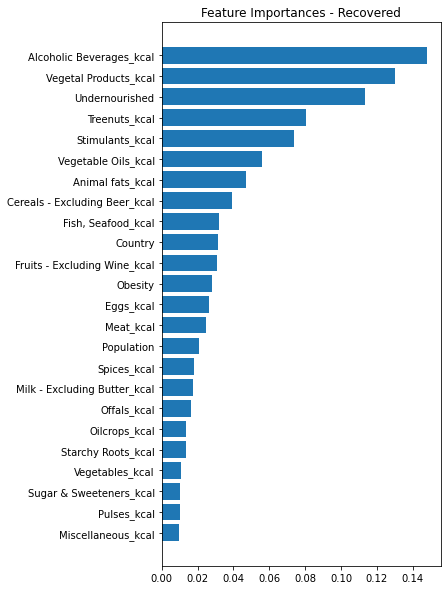

<Figure size 432x288 with 0 Axes>

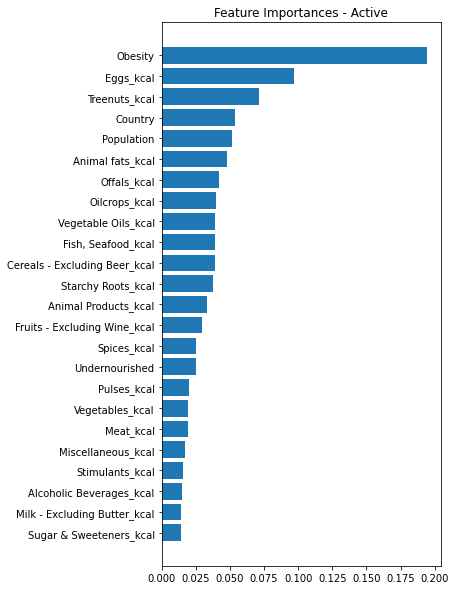

In [75]:
for t in targets:
    data_num = x_features_slct[t].select_dtypes(include = ['float64', 'int64'])
    data_cat = x_features_slct[t].select_dtypes(include = ['object'])
    colunas_num_slct = data_num.columns.tolist()
    colunas_categ_slct = data_cat.columns.tolist()
    
    x_features_importance_pratica = x_features_slct[t][features_slct[t]]
    
    features_names_sort_slct, feature_importances_sort_slct = importancia_das_features(x_features_importance_pratica, y_dict[t], colunas_numericas=colunas_num_slct, colunas_categoricas = colunas_categ_slct, nome_variavel = t)


## Separando dado de treino e teste

In [76]:
x_train_dict = {}
y_train_dict = {}
x_test_dict = {}
y_test_dict = {}

x_train_dict_sens = {}
y_train_dict_sens = {}
x_test_dict_sens = {}
y_test_dict_sens = {}

for t in targets:
    x_train_dict[t], x_test_dict[t], y_train_dict[t], y_test_dict[t] = train_test_split(x_features_slct[t], y_dict[t], test_size=0.01, random_state=42)
    x_train_dict_sens[t], x_test_dict_sens[t], y_train_dict_sens[t], y_test_dict_sens[t] = train_test_split(x_features_slct[t], y_dict[t], test_size=0.5, random_state=42)
    print (y_train_dict[t].shape, y_test_dict[t].shape)

(158,) (2,)
(158,) (2,)
(158,) (2,)
(158,) (2,)


## Pré processamento

In [77]:
colunas_a_normalizar = {}
colunas_a_codificar = {}
for t in targets:
    data_num = x_features_slct[t].select_dtypes(include = ['float64', 'int64'])
    data_cat = x_features_slct[t].select_dtypes(include = ['object'])
    colunas_a_normalizar[t] = data_num.columns.tolist()
    colunas_a_codificar[t] = data_cat.columns.tolist()

scaler_dict = {}
for t in targets:
    _, scaler = normalizar_numericas(x_train_dict[t], colunas_a_normalizar[t])
    _, scaler_sens = normalizar_numericas(x_train_dict_sens[t], colunas_a_normalizar[t])
    scaler_dict[t] = scaler
    x_test_dict[t][colunas_a_normalizar[t]] = scaler_dict[t].transform(x_test_dict[t][colunas_a_normalizar[t]])
    x_test_dict_sens[t][colunas_a_normalizar[t]] = scaler_sens.transform(x_test_dict_sens[t][colunas_a_normalizar[t]])

encoder_dict = {}
for t in targets:
    if colunas_a_codificar[t] == []: continue
    x_train_dict[t], enc = codificar_categoricas(x_train_dict[t], colunas_categoricas = colunas_a_codificar[t])
    x_train_dict_sens[t], enc_sens = codificar_categoricas(x_train_dict_sens[t], colunas_categoricas = colunas_a_codificar[t])
    encoder_dict[t] = enc
    test_categ = pd.DataFrame(enc.transform(x_test_dict[t][colunas_a_codificar[t]]).toarray())
    x_test_dict[t].reset_index(inplace=True, drop=True)
    x_test_dict[t] = pd.concat([test_categ, x_test_dict[t][colunas_a_normalizar[t]]], axis=1)
    
    test_categ_sens = pd.DataFrame(enc_sens.transform(x_test_dict_sens[t][colunas_a_codificar[t]]).toarray())
    x_test_dict_sens[t].reset_index(inplace=True, drop=True)
    x_test_dict_sens[t] = pd.concat([test_categ_sens, x_test_dict_sens[t][colunas_a_normalizar[t]]], axis=1)

/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/joaoweissmann/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


## Análise de sensibilidade

In [78]:
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
msle_scorer = make_scorer(mean_squared_log_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score, greater_is_better=True)

metricas = {'mse': mse_scorer,
            'mae': mae_scorer
           }

errors = [mean_squared_error, mean_absolute_error]

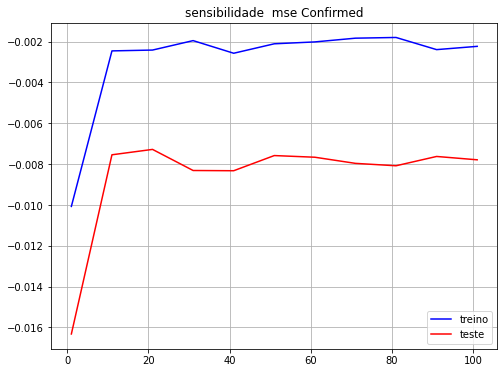

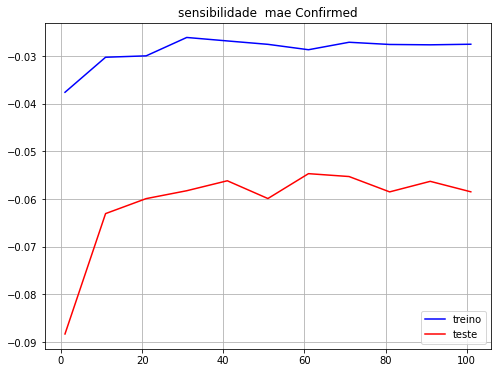

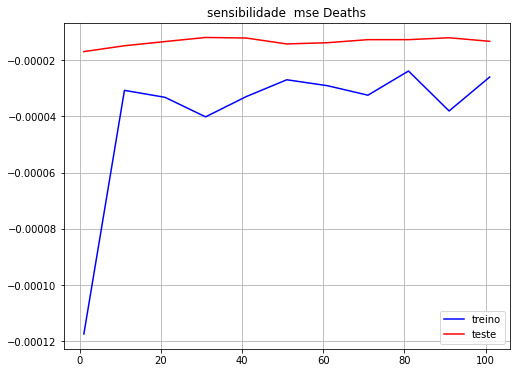

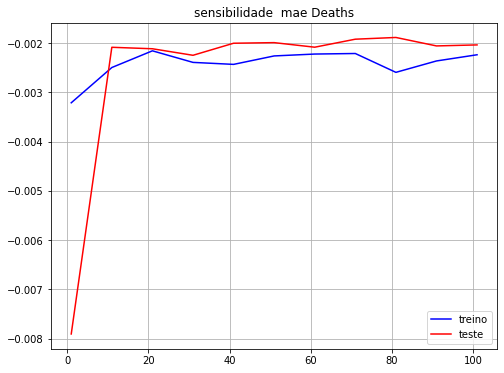

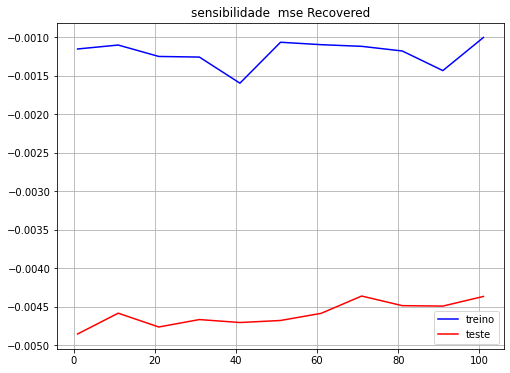

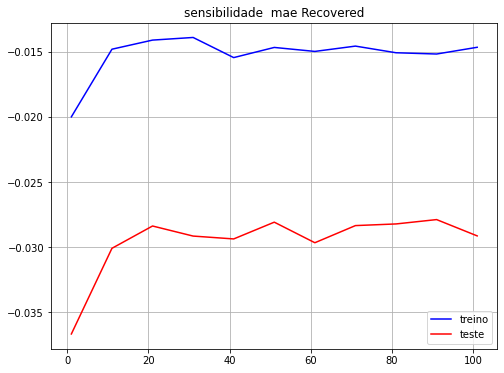

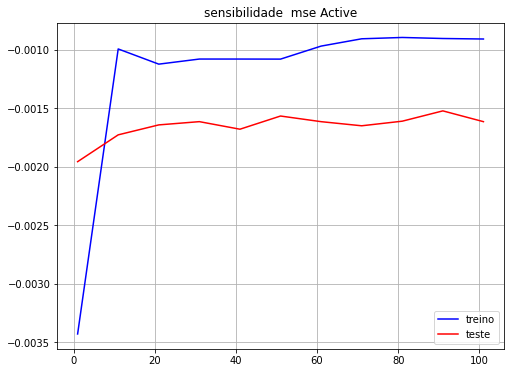

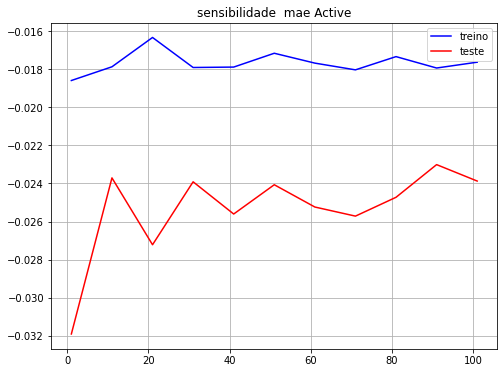

In [79]:
lista_n_arvores = [i for i in range(1, 111, 10)]

for t in targets:
    for met_nome, metrica in metricas.items():
        train_results = []
        test_results = []
        for n_arvores in lista_n_arvores:
            model = BaggingRegressor(base_estimator=ExtraTreeRegressor(), 
                                     n_estimators=n_arvores,
                                     n_jobs = -1)

            model.fit(x_train_dict_sens[t], y_train_dict_sens[t])
            train_pred = model.predict(x_train_dict_sens[t])
            test_pred = model.predict(x_test_dict_sens[t])
            train_r2 = metrica(model, x_train_dict_sens[t], y_train_dict_sens[t])
            test_r2 = metrica(model, x_test_dict_sens[t], y_test_dict_sens[t])
            train_results.append(train_r2)
            test_results.append(test_r2)

        plt.figure(figsize=(8,6))
        plt.plot(lista_n_arvores, train_results, 'b', label="treino")
        plt.plot(lista_n_arvores, test_results, 'r', label="teste")
        plt.title('sensibilidade ' + ' ' + met_nome + ' ' + t)
        plt.legend()
        plt.grid()

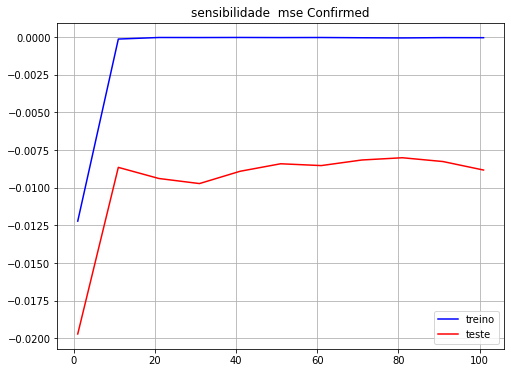

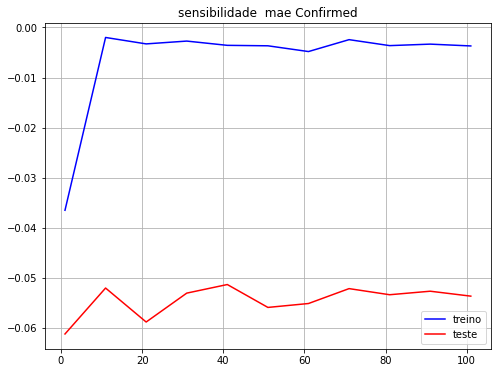

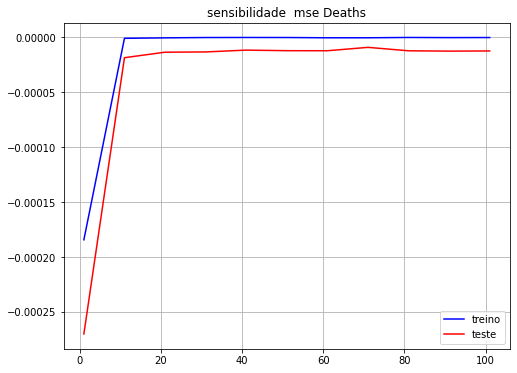

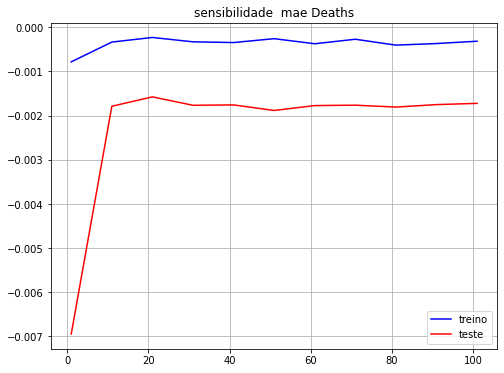

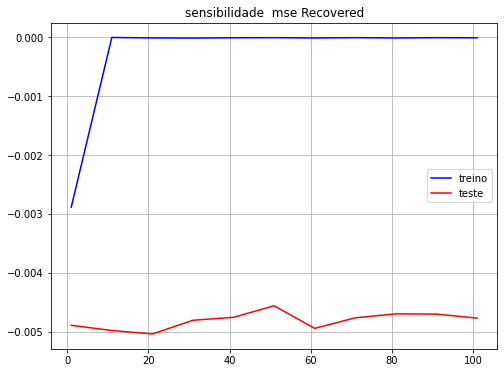

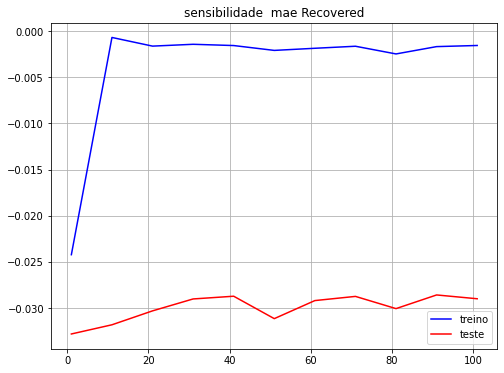

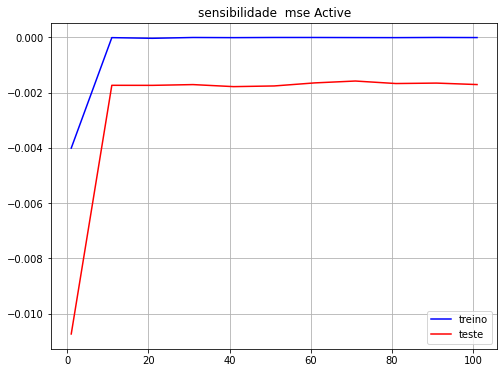

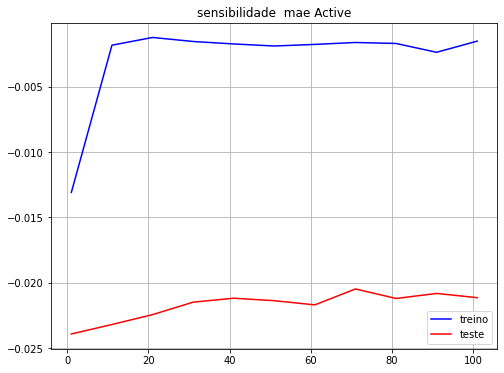

In [80]:
lista_n_arvores = [i for i in range(1, 111, 10)]

for t in targets:
    for met_nome, metrica in metricas.items():
        train_results = []
        test_results = []
        for n_arvores in lista_n_arvores:
            model = AdaBoostRegressor(base_estimator=ExtraTreeRegressor(), 
                                      n_estimators=n_arvores)

            model.fit(x_train_dict_sens[t], y_train_dict_sens[t])
            train_pred = model.predict(x_train_dict_sens[t])
            test_pred = model.predict(x_test_dict_sens[t])
            train_r2 = metrica(model, x_train_dict_sens[t], y_train_dict_sens[t])
            test_r2 = metrica(model, x_test_dict_sens[t], y_test_dict_sens[t])
            train_results.append(train_r2)
            test_results.append(test_r2)

        plt.figure(figsize=(8,6))
        plt.plot(lista_n_arvores, train_results, 'b', label="treino")
        plt.plot(lista_n_arvores, test_results, 'r', label="teste")
        plt.title('sensibilidade ' + ' ' + met_nome + ' ' + t)
        plt.legend()
        plt.grid()

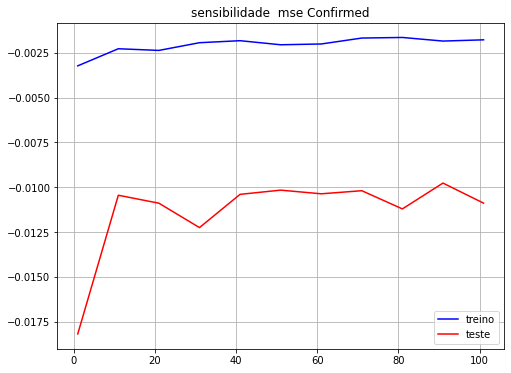

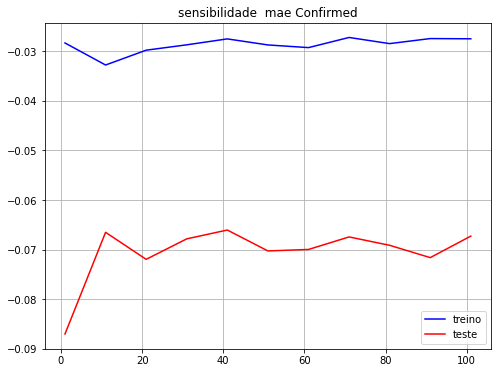

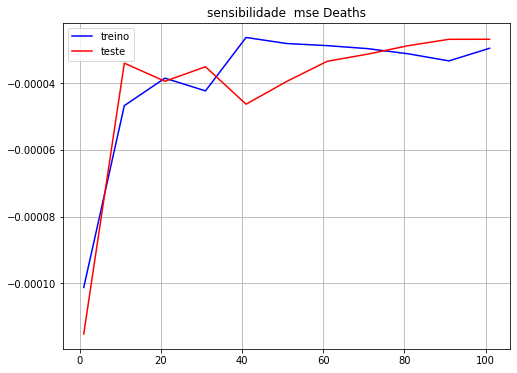

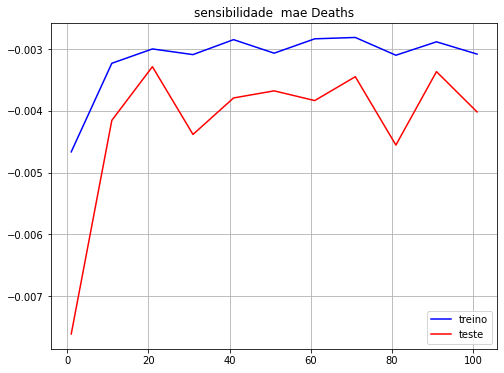

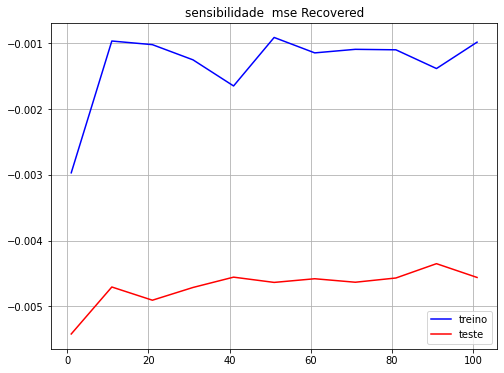

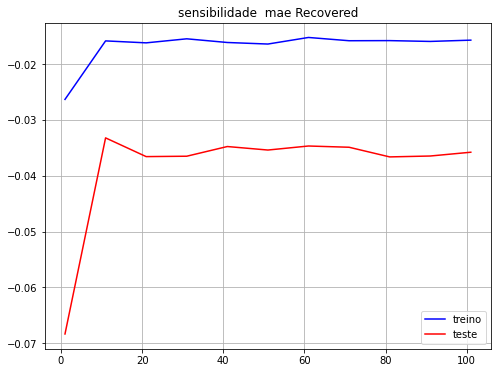

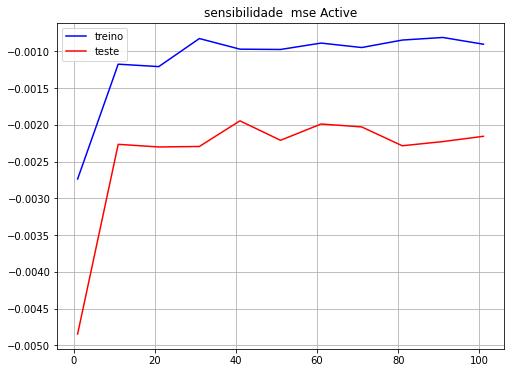

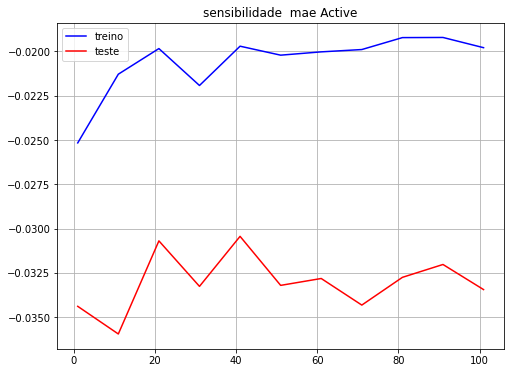

In [81]:
lista_n_arvores = [i for i in range(1, 111, 10)]

for t in targets:
    for met_nome, metrica in metricas.items():
        train_results = []
        test_results = []
        for n_arvores in lista_n_arvores:
            model = RandomForestRegressor(n_estimators=n_arvores,
                                     n_jobs = -1)

            model.fit(x_train_dict_sens[t], y_train_dict_sens[t])
            train_pred = model.predict(x_train_dict_sens[t])
            test_pred = model.predict(x_test_dict_sens[t])
            train_r2 = metrica(model, x_train_dict_sens[t], y_train_dict_sens[t])
            test_r2 = metrica(model, x_test_dict_sens[t], y_test_dict_sens[t])
            train_results.append(train_r2)
            test_results.append(test_r2)

        plt.figure(figsize=(8,6))
        plt.plot(lista_n_arvores, train_results, 'b', label="treino")
        plt.plot(lista_n_arvores, test_results, 'r', label="teste")
        plt.title('sensibilidade ' + ' ' + met_nome + ' ' + t)
        plt.legend()
        plt.grid()

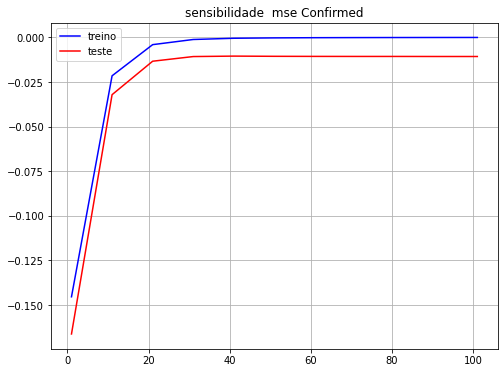

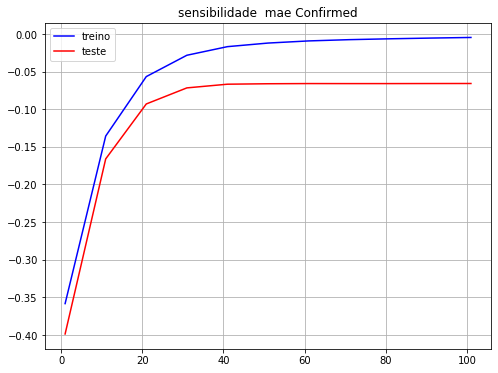

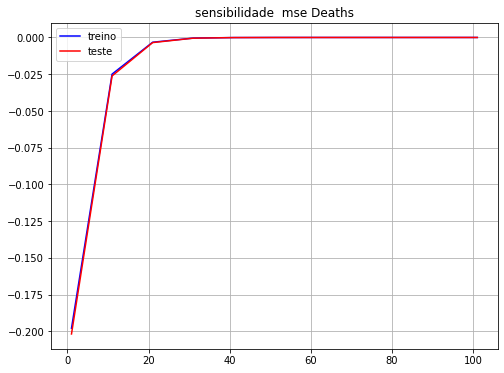

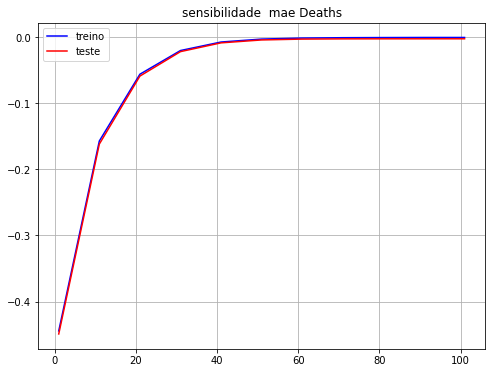

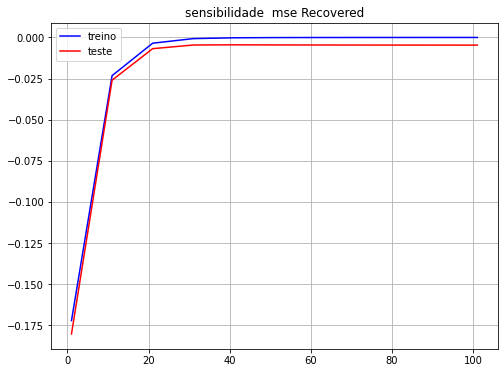

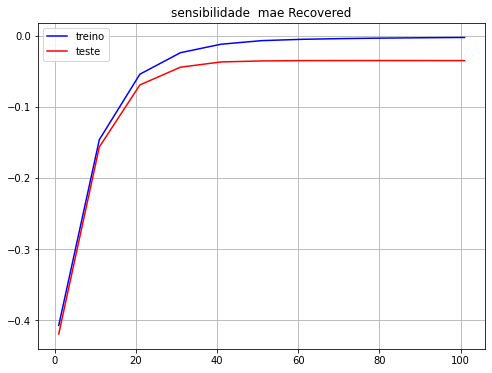

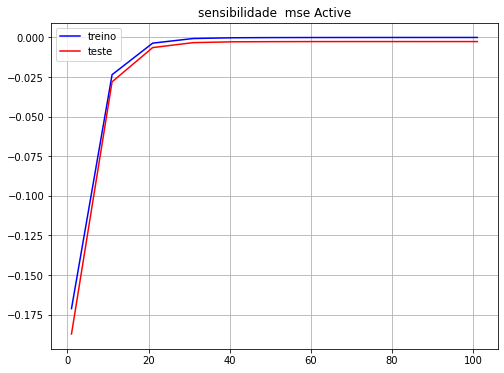

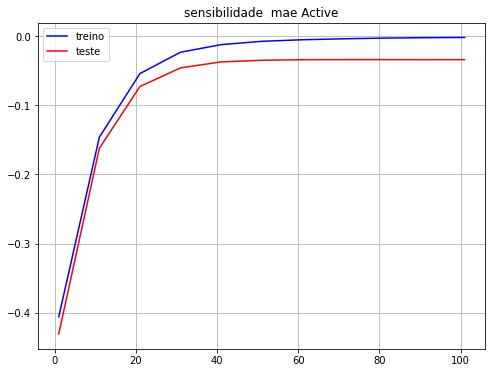

In [82]:
lista_n_arvores = [i for i in range(1, 111, 10)]

for t in targets:
    for met_nome, metrica in metricas.items():
        train_results = []
        test_results = []
        for n_arvores in lista_n_arvores:
            model = xgb.XGBRegressor(n_estimators=n_arvores,
                                     n_jobs = -1, objective='reg:squarederror')

            model.fit(x_train_dict_sens[t], y_train_dict_sens[t])
            train_pred = model.predict(x_train_dict_sens[t])
            test_pred = model.predict(x_test_dict_sens[t])
            train_r2 = metrica(model, x_train_dict_sens[t], y_train_dict_sens[t])
            test_r2 = metrica(model, x_test_dict_sens[t], y_test_dict_sens[t])
            train_results.append(train_r2)
            test_results.append(test_r2)

        plt.figure(figsize=(8,6))
        plt.plot(lista_n_arvores, train_results, 'b', label="treino")
        plt.plot(lista_n_arvores, test_results, 'r', label="teste")
        plt.title('sensibilidade ' + ' ' + met_nome + ' ' + t)
        plt.legend()
        plt.grid()

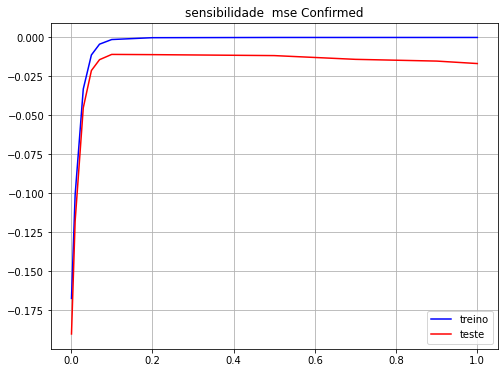

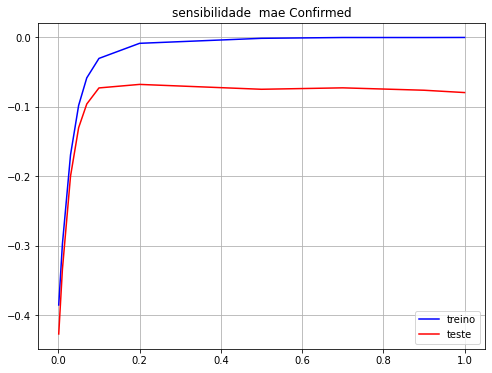

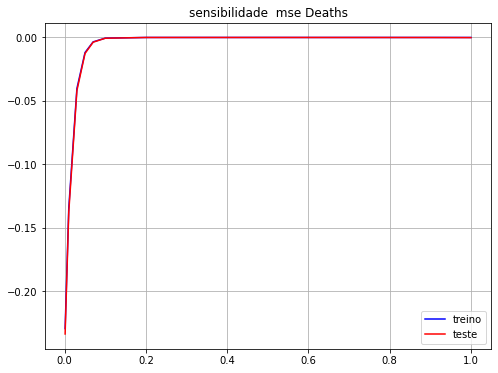

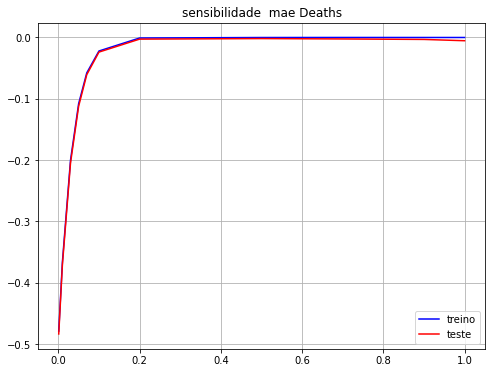

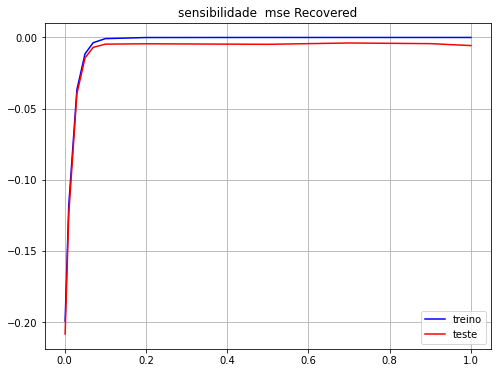

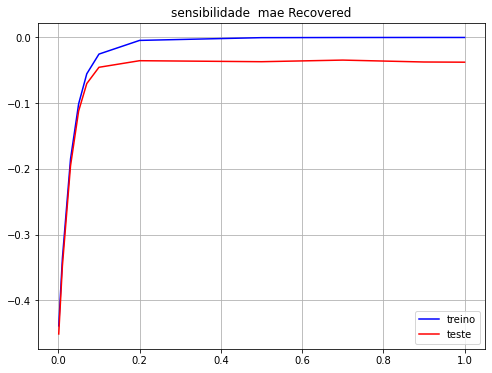

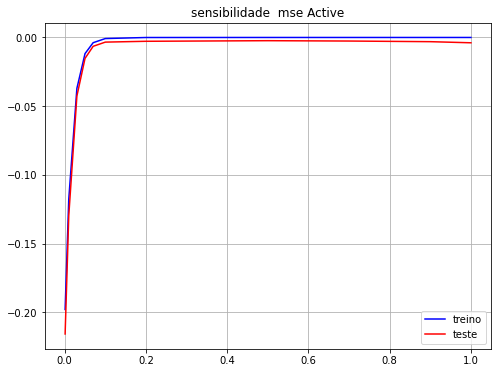

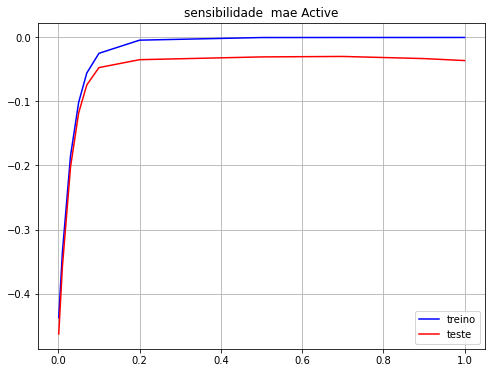

In [97]:
lista_learning_rate = [0.001, 0.01, 0.03, 0.05, 0.07, 0.1, 0.2, 0.5, 0.7, 0.9, 1.]

for t in targets:
    for met_nome, metrica in metricas.items():
        train_results = []
        test_results = []
        for lr in lista_learning_rate:
            model = xgb.XGBRegressor(n_estimators=30,
                                     learning_rate=lr,
                                     n_jobs = -1, objective='reg:squarederror')

            model.fit(x_train_dict_sens[t], y_train_dict_sens[t])
            train_pred = model.predict(x_train_dict_sens[t])
            test_pred = model.predict(x_test_dict_sens[t])
            train_r2 = metrica(model, x_train_dict_sens[t], y_train_dict_sens[t])
            test_r2 = metrica(model, x_test_dict_sens[t], y_test_dict_sens[t])
            train_results.append(train_r2)
            test_results.append(test_r2)

        plt.figure(figsize=(8,6))
        plt.plot(lista_learning_rate, train_results, 'b', label="treino")
        plt.plot(lista_learning_rate, test_results, 'r', label="teste")
        plt.title('sensibilidade ' + ' ' + met_nome + ' ' + t)
        plt.legend()
        plt.grid()

## Model selection: otimização

In [83]:
modelos_dict = {'ridge': Ridge(),
                'lasso': Lasso(),
                'bagging': BaggingRegressor(),
                'adaboost': AdaBoostRegressor(),
                'random forest': RandomForestRegressor(),
                'gradient boosting':xgb.XGBRegressor(),
                }

ridge_param_grid = {'alpha': stats.uniform(loc=0.001, scale=1000),
                    'max_iter': np.arange(1000, 10000, 1000),
                    }

lasso_param_grid = {'alpha': stats.uniform(loc=0.001, scale=1000),
                    'max_iter': np.arange(1000, 10000, 1000),
                    }

bagging_param_grid = {'base_estimator': [DecisionTreeRegressor(), ExtraTreeRegressor(), Ridge(), Lasso()], 
                      'n_estimators': [10, 20, 30, 40, 50], 
                      'max_samples': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
                      'max_features': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
                      'bootstrap': [True], 
                      'bootstrap_features': [False, True],
                      'n_jobs': [-1]
                     }

adaboost_param_grid = {'base_estimator': [DecisionTreeRegressor(), ExtraTreeRegressor(), Ridge(), Lasso()],
                       'n_estimators': [10, 20, 30, 40, 50], 
                       'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 
                       'loss': ['linear', 'square', 'exponential']
                      }

rf_param_grid = {'n_estimators': [10, 20, 30, 40, 50],
                 'max_features': np.arange(1, 20, 1),
                 'max_depth':np.arange(1, 20, 1),
                 'min_samples_split': np.arange(2, 20, 1),
                 "bootstrap": [True, False],
                 'n_jobs': [-1]
                 }

gdbt_param_grid = {'max_depth': np.arange(3, 20, 1),
                   'learning_rate': stats.uniform(loc=0.1, scale=0.3),
                   'n_estimators': [10, 20, 30, 40, 50],
                   'n_jobs': [-1],
                   'gamma': stats.uniform(loc=0.001, scale=10),
                   'subsample': stats.uniform(loc=0.1, scale=0.9),
                   'colsample_bytree': stats.uniform(loc=0.1, scale=0.9),
                   'reg_alpha': stats.uniform(loc=0.001, scale=10),
                   'reg_lambda': stats.uniform(loc=0.01, scale=5),
                   'booster': ['gbtree', 'gblinear', 'dart'],
                   'objective': ['reg:squarederror']
                   }


param_dict = {'ridge':ridge_param_grid,
              'lasso': lasso_param_grid,
              'bagging': bagging_param_grid,
              'adaboost': adaboost_param_grid,
              'random forest': rf_param_grid,
              'gradient boosting':gdbt_param_grid,
             }

In [84]:
n_iteracoes = 10

In [85]:
%%time

resultados_dict = {}
otm_time_dict = {}
melhor_modelo_dict = {}
melhor_modelo_nome = {}
melhores_parametros_dict = {}
best_score = {}
resultados = {}

n_folds = 10

loo = LeaveOneOut()

for t in targets:
    _, _, _, resultados[t], _ = busca_aleatoria(x_train_dict[t], y_train_dict[t], Ridge(), param_dict['ridge'], metricas, n_folds=loo.split(x_train_dict[t]), n_iter=n_iteracoes)
    resultados[t]['nome'] = 'ridge'

for t in targets:
    best_score[t] = -9999.
    melhor_modelo_nome[t] = None
    melhor_modelo_dict[t] = None
    melhores_parametros_dict[t] = None
    for nome, modelo in modelos_dict.items():
        print (nome)
        melhor_modelo, melhores_parametros, score, result, otm_time = busca_aleatoria(x_train_dict[t], y_train_dict[t], modelo, param_dict[nome], metricas, n_folds=loo.split(x_train_dict[t]), n_iter=n_iteracoes)
        result['nome'] = nome
        resultados[t] = pd.concat([resultados[t], result])
        if score > best_score[t]:
            melhor_modelo_nome[t] = nome
            melhor_modelo_dict[t] = melhor_modelo
            melhores_parametros_dict[t] = melhores_parametros
            best_score[t] = score



 
 buscando melhores parâmetros...
melhores parâmetros encontrados

 
 buscando melhores parâmetros...
melhores parâmetros encontrados

 
 buscando melhores parâmetros...
melhores parâmetros encontrados

 
 buscando melhores parâmetros...
melhores parâmetros encontrados
ridge

 
 buscando melhores parâmetros...
melhores parâmetros encontrados
lasso

 
 buscando melhores parâmetros...
melhores parâmetros encontrados
bagging

 
 buscando melhores parâmetros...
melhores parâmetros encontrados
adaboost

 
 buscando melhores parâmetros...
melhores parâmetros encontrados
random forest

 
 buscando melhores parâmetros...
melhores parâmetros encontrados
gradient boosting

 
 buscando melhores parâmetros...
melhores parâmetros encontrados
ridge

 
 buscando melhores parâmetros...
melhores parâmetros encontrados
lasso

 
 buscando melhores parâmetros...
melhores parâmetros encontrados
bagging

 
 buscando melhores parâmetros...
melhores parâmetros encontrados
adaboost

 
 buscando melhores parâ

In [86]:
for t in targets:
    print (resultados[t].shape)
    resultados[t].sort_values(by='mean_test_'+list(metricas.keys())[0], inplace=True, ascending=False)

(70, 348)
(70, 348)
(70, 348)
(70, 348)


In [87]:
for t in targets:
    for i, (met_nome, metrica) in enumerate(metricas.items()):
        print (met_nome, t, resultados[t]['mean_test_'+list(metricas.keys())[i]].max())

mse Confirmed -0.010511524400075073
mae Confirmed -0.060234467790415906
mse Deaths -0.0001016189755039911
mae Deaths -0.003912657167918309
mse Recovered -0.005413394392739142
mae Recovered -0.035043382785863914
mse Active -0.0037184458522409136
mae Active -0.033018925491932596


In [88]:
for t in targets:
    print (t, best_score[t])

Confirmed -0.010511524400075073
Deaths -0.0001016189755039911
Recovered -0.005413394392739142
Active -0.0037184458522409136


In [89]:
resultados['Confirmed'][['mean_test_mse', 'std_test_mse', 'rank_test_mse', 
                         'mean_test_mae', 'std_test_mae', 'rank_test_mae',
                         'nome']].head(20)

,mean_test_mse,std_test_mse,rank_test_mse,mean_test_mae,std_test_mae,rank_test_mae,nome
7,-0.010512,0.025517,1,-0.067500,0.077170,1,random forest
6,-0.010963,0.026728,2,-0.069583,0.078240,3,random forest
4,-0.010994,0.024121,1,-0.068201,0.079644,2,bagging
1,-0.011054,0.023525,2,-0.069307,0.079062,4,bagging
5,-0.011097,0.028508,3,-0.066367,0.081810,1,bagging
2,-0.011149,0.027132,3,-0.071124,0.078042,4,random forest
9,-0.011206,0.026696,4,-0.068232,0.080937,2,random forest
2,-0.011432,0.026084,4,-0.070216,0.080636,5,bagging
0,-0.011467,0.027947,5,-0.072730,0.078594,6,random forest
3,-0.011529,0.027877,6,-0.073547,0.078232,7,random forest


In [90]:
resultados['Deaths'][['mean_test_mse', 'std_test_mse', 'rank_test_mse', 
                         'mean_test_mae', 'std_test_mae', 'rank_test_mae',
                         'nome']].head(20)

,mean_test_mse,std_test_mse,rank_test_mse,mean_test_mae,std_test_mae,rank_test_mae,nome
2,-0.000102,0.000439,1,-0.004631,0.008954,2,random forest
6,-0.000103,0.000490,2,-0.004592,0.009074,1,random forest
5,-0.000106,0.000498,3,-0.004788,0.009115,3,random forest
4,-0.000109,0.000492,1,-0.004696,0.009330,2,bagging
4,-0.000110,0.000507,4,-0.005239,0.009082,5,random forest
3,-0.000112,0.000505,2,-0.004744,0.009469,4,bagging
0,-0.000114,0.000532,5,-0.005162,0.009358,4,random forest
6,-0.000115,0.000497,3,-0.005640,0.009122,7,bagging
1,-0.000115,0.000495,4,-0.004889,0.009550,5,bagging
7,-0.000117,0.000506,1,-0.005458,0.009327,2,ridge


In [91]:
resultados['Recovered'][['mean_test_mse', 'std_test_mse', 'rank_test_mse', 
                         'mean_test_mae', 'std_test_mae', 'rank_test_mae',
                         'nome']].head(20)

,mean_test_mse,std_test_mse,rank_test_mse,mean_test_mae,std_test_mae,rank_test_mae,nome
9,-0.005413,0.025493,1,-0.036474,0.063899,1,random forest
7,-0.005659,0.025992,2,-0.039822,0.063823,5,random forest
6,-0.005695,0.026215,3,-0.038544,0.064878,2,random forest
5,-0.005749,0.025826,4,-0.040596,0.064041,7,random forest
1,-0.005755,0.026460,5,-0.039040,0.065043,3,random forest
4,-0.005872,0.026351,6,-0.039605,0.065602,4,random forest
0,-0.005901,0.024598,7,-0.042973,0.063671,8,random forest
6,-0.005918,0.024159,1,-0.040261,0.065553,7,bagging
7,-0.006010,0.026611,1,-0.042693,0.064713,1,ridge
4,-0.006016,0.026507,1,-0.042812,0.064674,3,ridge


In [92]:
resultados['Active'][['mean_test_mse', 'std_test_mse', 'rank_test_mse', 
                         'mean_test_mae', 'std_test_mae', 'rank_test_mae',
                         'nome']].head(20)

,mean_test_mse,std_test_mse,rank_test_mse,mean_test_mae,std_test_mae,rank_test_mae,nome
5,-0.003718,0.010059,1,-0.039443,0.046505,2,random forest
9,-0.003743,0.009904,2,-0.039473,0.046742,3,random forest
8,-0.003747,0.009987,3,-0.039200,0.047015,1,random forest
3,-0.003767,0.010402,4,-0.039607,0.046882,4,random forest
7,-0.003859,0.010598,5,-0.040847,0.046804,8,random forest
4,-0.003878,0.010276,6,-0.040721,0.047114,6,random forest
2,-0.003932,0.010972,7,-0.040357,0.047995,5,random forest
8,-0.003971,0.011373,1,-0.039151,0.049382,5,bagging
1,-0.004002,0.011071,8,-0.041441,0.047795,10,random forest
0,-0.004071,0.011602,9,-0.040826,0.049029,7,random forest


## Testar modelo

In [93]:
for t in targets:
    modelo = melhor_modelo_dict[t]
    if modelo == None: continue
    modelo.fit(x_train_dict[t], y_train_dict[t])

tabela_compara_dict = {}
train_scores = {}
test_scores = {}
biases = {}
variances = {}

for t in targets:
    modelo = melhor_modelo_dict[t]
    
    tabela_compara_dict[t+' treino'] = []
    tabela_compara_dict[t+' treino baseline'] = []
    
    for i, (met_nome, metrica) in enumerate(metricas.items()):
        if modelo == None: continue
        
        train_scores[t] = metrica(modelo, x_train_dict[t], y_train_dict[t]) 
        test_scores[t] = metrica(modelo, x_test_dict[t], y_test_dict[t])
        
        baseline_train = errors[i](y_train_dict[t], np.ones((y_train_dict[t].shape)) * y_train_dict[t].mean())
        baseline_test = errors[i](y_test_dict[t], np.ones((y_test_dict[t].shape)) * y_train_dict[t].mean())
        
        print ( met_nome + ": score de treino " + str(-metrica(modelo, x_train_dict[t], y_train_dict[t]).round(4)) + " e score de teste: " + str(-metrica(modelo, x_test_dict[t], y_test_dict[t]).round(4)) + " para target: " + str(t))
        print ( met_nome + ": baseline treino " + str(baseline_train.round(4)) + " baseline teste: " + str(baseline_test.round(4)) + " para target: " + str(t))
        
        tabela_compara_dict[t+' treino baseline'].append(baseline_train)
        tabela_compara_dict[t+' treino'].append(-metrica(modelo, x_train_dict[t], y_train_dict[t]))
        

mse: score de treino 0.0018 e score de teste: 0.0003 para target: Confirmed
mse: baseline treino 0.0164 baseline teste: 0.0033 para target: Confirmed
mae: score de treino 0.0296 e score de teste: 0.0175 para target: Confirmed
mae: baseline treino 0.0956 baseline teste: 0.0428 para target: Confirmed
mse: score de treino 0.0 e score de teste: 0.0 para target: Deaths
mse: baseline treino 0.0001 baseline teste: 0.0 para target: Deaths
mae: score de treino 0.0009 e score de teste: 0.0008 para target: Deaths
mae: baseline treino 0.006 baseline teste: 0.0025 para target: Deaths
mse: score de treino 0.0003 e score de teste: 0.0008 para target: Recovered
mse: baseline treino 0.0073 baseline teste: 0.0011 para target: Recovered
mae: score de treino 0.0115 e score de teste: 0.0242 para target: Recovered
mae: baseline treino 0.0512 baseline teste: 0.0314 para target: Recovered
mse: score de treino 0.0017 e score de teste: 0.0001 para target: Active
mse: baseline treino 0.0046 baseline teste: 0.000

In [94]:
for t in targets:
    for i, (met_nome, metrica) in enumerate(metricas.items()):
        print (met_nome, 'leave one out treino', t, resultados[t]['mean_test_'+list(metricas.keys())[i]].min())

mse leave one out treino Confirmed -0.1076475053805195
mae leave one out treino Confirmed -0.31207437663319515
mse leave one out treino Deaths -0.007063702476531804
mae leave one out treino Deaths -0.08321526473056044
mse leave one out treino Recovered -0.1963469266650027
mae leave one out treino Recovered -0.43655059859904083
mse leave one out treino Active -0.16447534475659453
mae leave one out treino Active -0.3995520449008158


In [95]:
tabela_compara = pd.DataFrame.from_dict(tabela_compara_dict, orient='index', columns=['MSE', 'MAE'])

In [96]:
tabela_compara

,MSE,MAE
Confirmed treino,0.001786,0.029633
Confirmed treino baseline,0.016403,0.095625
Deaths treino,0.000003,0.000928
Deaths treino baseline,0.000134,0.006047
Recovered treino,0.000331,0.011546
Recovered treino baseline,0.007324,0.051161
Active treino,0.001728,0.028502
Active treino baseline,0.004572,0.045398
